In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as nnf
from torch.utils.data import TensorDataset, DataLoader
import torcheval.metrics
import time

from sklearn.datasets import make_moons

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
from tools import *

assert(torch.cuda.is_available())
device = torch.device("cuda")

c:\Users\Miguel\miniconda3\envs\ml3\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


<Axes: >

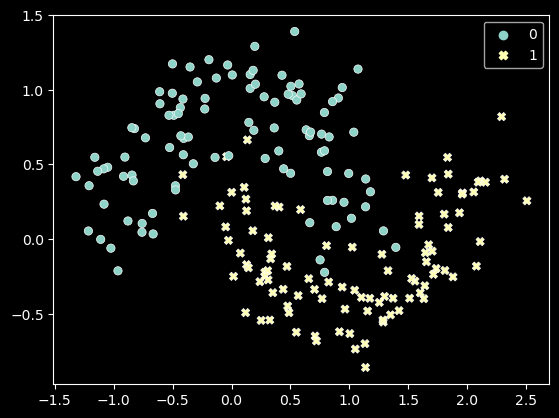

In [2]:
X_train, y_train = make_moons(n_samples=8000, noise=0.2)
X_test, y_test = make_moons(n_samples=200, noise=0.2)
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_test, style=y_test)


In [3]:
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader_32 = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
# training_loader_256 = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
testing_loader_32 = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

optimizer = torch.optim.AdamW(model.parameters())
f_loss = torch.nn.functional.cross_entropy

In [4]:
y0_hat = model(train_dataset[:50][0].to(device))
y0 = train_dataset[:50][1].to(device)
print(y0_hat.shape)
print(y0.shape)

torch.Size([50, 2])
torch.Size([50])


In [5]:
#our classifier returns a [batch_len, n_classes] tensor of logits. but the
#torcheval metrics expect a [batch_len,] tensor of integer class labels, so we
#need to apply argmax along each row of the classifier output to get the
#predicted class
print(torcheval.metrics.functional.binary_accuracy( torch.argmax(y0_hat, axis=1) , y0))
print(torcheval.metrics.functional.binary_f1_score( torch.argmax(y0_hat, axis=1) , y0))

tensor(0.3200, device='cuda:0')
tensor(0., device='cuda:0')


In [6]:
#to apply this preprocessing automatically to any metric functional, we pass the
#functional to the from_logits wrapper and use the wrapped functional
binary_accuracy_from_logits = from_logits(torcheval.metrics.functional.binary_accuracy)
binary_f1_from_logits = from_logits(torcheval.metrics.functional.binary_f1_score)
print(binary_accuracy_from_logits(y0_hat, y0))
print(binary_f1_from_logits(y0_hat, y0))

metrics = {"Cross-Entropy Loss": torch.nn.functional.cross_entropy, "Accuracy": binary_accuracy_from_logits, "F1 Score": binary_f1_from_logits}

tensor(0.3200, device='cuda:0')
tensor(0., device='cuda:0')


In [7]:
eval_loaders = {"Train": training_loader_32, "Test": testing_loader_32}
results = train_network( model, f_loss, optimizer, training_loader_32, eval_loaders=eval_loaders, eval_metrics=metrics, final_epoch=10)
results

Epoch: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


,Epochs Trained,Accumulated Time,Train Cross-Entropy Loss,Train Accuracy,Train F1 Score,Test Cross-Entropy Loss,Test Accuracy,Test F1 Score
0,0,0.000000,0.739506,0.341500,0.000000,0.738693,0.345,0.000000
1,1,0.356186,0.295390,0.872000,0.873829,0.283844,0.885,0.887805
2,2,0.684652,0.292121,0.873625,0.876512,0.281760,0.885,0.888889
3,3,1.020601,0.278854,0.881500,0.882060,0.270663,0.890,0.892157
4,4,1.355336,0.253996,0.891250,0.892540,0.249411,0.900,0.901961
5,5,1.715369,0.209009,0.916625,0.914782,0.211594,0.900,0.896907
6,6,2.046245,0.142390,0.952250,0.952863,0.156104,0.940,0.941176
7,7,2.389567,0.109572,0.961500,0.961442,0.122633,0.950,0.950495
8,8,2.718210,0.103420,0.961750,0.962500,0.124901,0.945,0.946342
9,9,3.058827,0.089993,0.965875,0.965828,0.107904,0.940,0.940000


In [8]:
tstart = time.time()
scores = eval_network(model, {"Train": training_loader_32, "Test": testing_loader_32}, metrics)
tend = time.time()
tend-tstart

NameError: name 'training_loader_256' is not defined